In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO

import torch
import torch.nn.functional as F

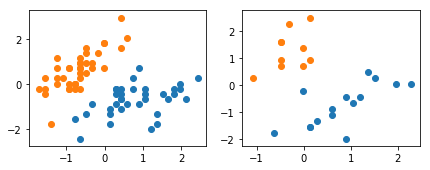

In [6]:
##########################
### DATASET
##########################

ds = np.lib.DataSource()
fp = ds.open('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')

x = np.genfromtxt(BytesIO(fp.read().encode()), delimiter=',', usecols=range(2), max_rows=100)
y = np.zeros(100)
y[50:] = 1

np.random.seed(1)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
plt.show()

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class LogisticRegression():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

    def forward(self, x):
        z = torch.mm(x, self.weights) + self.bias
        a = self._sigmoid(z)
        return a
        
    def backward(self, a, y):
        gradients = y - a.view(-1)
        return gradients 
    
    def _sigmoid(self, z):
        return 1 / (1 + torch.exp(-z))
    
    def _logit_cost(self, y, a):
        tmp1 = torch.mm(-y.view(1, -1), torch.log(a))
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - a))
        return tmp1 - tmp2
    
    def train(self, x, y, num_epochs, learning_rate=0.01):
        costs = []
        for e in range(num_epochs):
            
            # forward propagation
            a = self.forward(x)
            
            # backward propagation
            dz = self.backward(a, y)
            dw = torch.mm(x.transpose(0, 1), dz.view(-1, 1))
            db = torch.sum(dz)
            
            # update parameters
            self.weights += learning_rate * dw
            self.bias += learning_rate * db
            
            # accumulate loss
            cost = self._logit_cost(y, self.forward(x))    
            costs.append(cost)
            
        
        costs = np.squeeze(costs)
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

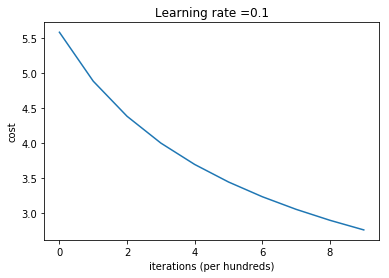


Model parameters:
  Weights: tensor([[ 4.2267],
        [-2.9613]])
  Bias: tensor([0.0994])


In [16]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

logr = LogisticRegression(num_features=2)
logr.train(X_train_tensor, y_train_tensor, num_epochs=10, learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % logr.weights)
print('  Bias: %s' % logr.bias)